# 1


--- Dataset head ---
  neighbourhood_cleansed  price  estimated_occupancy_l365d  \
0       Prospect Heights  200.0                          0   
1            East Harlem   82.0                          0   
2            Boerum Hill  765.0                          0   
3                 Harlem  139.0                        255   
4           Williamsburg  130.0                        154   

   estimated_revenue_l365d  availability_365  instant_bookable  is_long_term  \
0                      0.0               362                 0             1   
1                      0.0               204                 0             1   
2                      0.0               326                 0             0   
3                  35445.0                25                 0             0   
4                  20020.0                38                 0             0   

   is_activate  amenities_cnt  accommodates  ...  \
0            0              7             1  ...   
1            1       

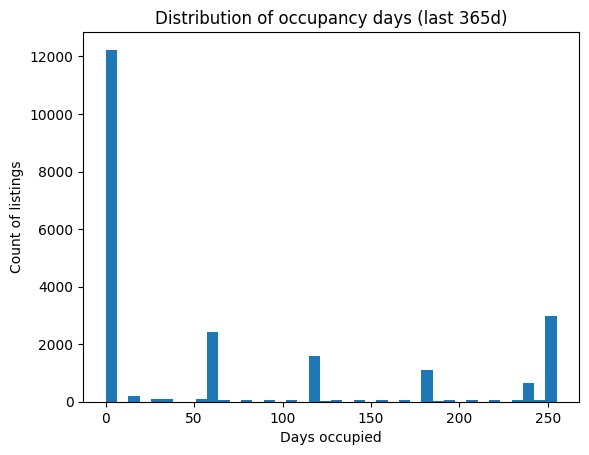


Top 15 Spearman correlations with target:
estimated_occupancy_l365d      1.000
number_of_reviews_ltm          0.987
estimated_revenue_l365d        0.972
number_of_reviews              0.604
is_activate                    0.574
host_is_superhost              0.443
amenities_cnt                  0.278
review_scores_communication    0.218
review_scores_rating           0.210
review_scores_checkin          0.203
review_scores_accuracy         0.200
review_scores_cleanliness      0.195
review_scores_value            0.176
host_acceptance_rate_score     0.156
description_length_group       0.139
Name: estimated_occupancy_l365d, dtype: float64
H1) Spearman rho(price, occupancy) = -0.081, p = 7.494e-34


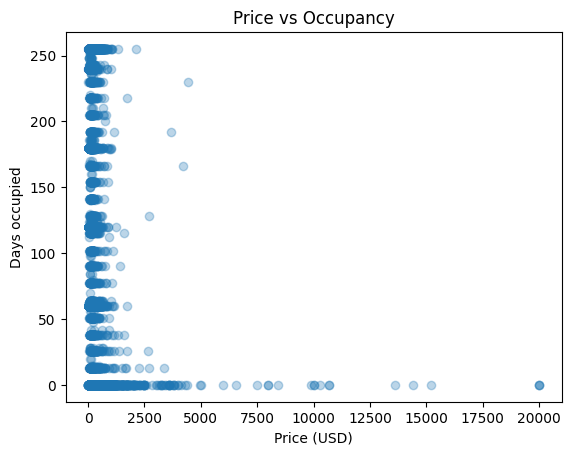

H2) Superhost mean = 141.8, Non-superhost mean = 44.9, t = 66.84, p = 0


<Figure size 640x480 with 0 Axes>

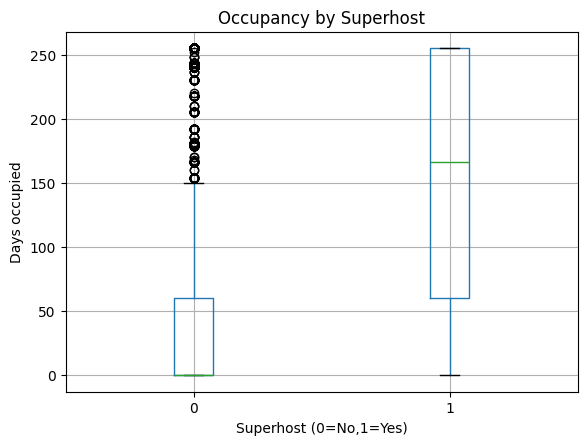

Leakage columns detected: ['estimated_revenue_l365d', 'number_of_reviews', 'number_of_reviews_ltm', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']
Baseline RMSE = 95.70
GBR → RMSE: 59.15, MAE: 40.92, R2: 0.618
RF → RMSE: 56.51, MAE: 35.18, R2: 0.651, OOB R2: 0.649


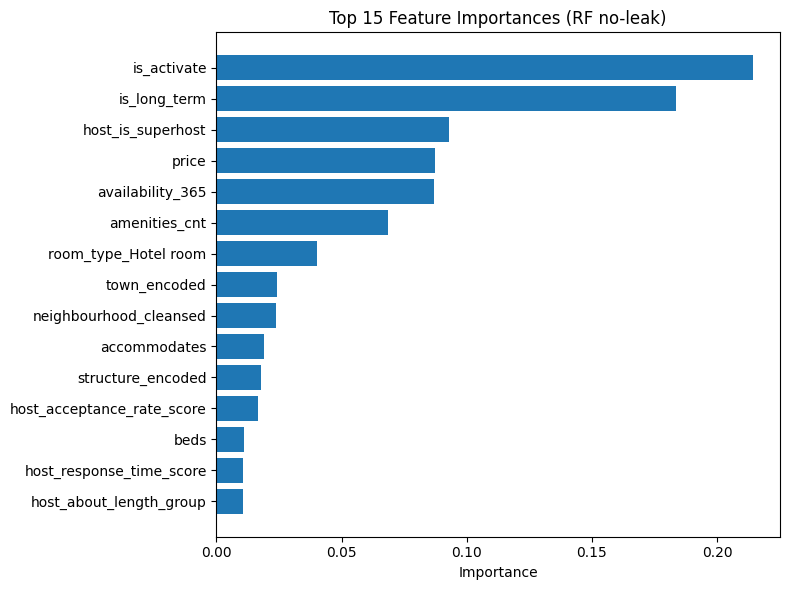

End of pipeline. You can import this module and call predict_occupancy() for new data.


In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, ttest_ind
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
import re
import warnings

warnings.filterwarnings("ignore")

# -------------------------------------------------
# 1. Load & inspect data
# -------------------------------------------------
DF_PATH = "book_df.csv"  # 경로를 실제 파일 위치로 수정하세요

df = pd.read_csv(DF_PATH)
df.drop(columns=[c for c in df.columns if c.startswith('Unnamed')], inplace=True, errors='ignore')

TARGET = "estimated_occupancy_l365d"
assert TARGET in df.columns, f"타깃 컬럼 '{TARGET}' 이(가) 없습니다."

print("--- Dataset head ---")
print(df.head(5))
print("--- Dataset shape ---", df.shape)
print(df[TARGET].describe().round(2))

# -------------------------------------------------
# 2. Exploratory Data Analysis (EDA)
# -------------------------------------------------
plt.figure()
plt.hist(df[TARGET], bins=40)
plt.title("Distribution of occupancy days (last 365d)")
plt.xlabel("Days occupied")
plt.ylabel("Count of listings")
plt.show()

# Numeric correlations with target
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[num_cols].corr(method="spearman")[TARGET].sort_values(ascending=False)
print("\nTop 15 Spearman correlations with target:")
print(corr.head(15).round(3))

# -------------------------------------------------
# 3. Hypothesis Testing
# -------------------------------------------------
# H1: 가격이 높을수록 예약일수는 줄어든다
rho, pval = spearmanr(df['price'], df[TARGET])
print(f"H1) Spearman rho(price, occupancy) = {rho:.3f}, p = {pval:.4g}")
plt.figure()
plt.scatter(df['price'], df[TARGET], alpha=0.3)
plt.title("Price vs Occupancy")
plt.xlabel("Price (USD)")
plt.ylabel("Days occupied")
plt.show()

# H2: 슈퍼호스트인지 여부에 따른 예약일수 차이
mask = df['host_is_superhost'] == 1
t_stat, t_p = ttest_ind(df.loc[mask, TARGET], df.loc[~mask, TARGET], equal_var=False)
print(f"H2) Superhost mean = {df.loc[mask, TARGET].mean():.1f}, Non-superhost mean = {df.loc[~mask, TARGET].mean():.1f}, t = {t_stat:.2f}, p = {t_p:.4g}")
plt.figure()
df.boxplot(column=TARGET, by='host_is_superhost')
plt.title("Occupancy by Superhost")
plt.suptitle("")
plt.xlabel("Superhost (0=No,1=Yes)")
plt.ylabel("Days occupied")
plt.show()

# -------------------------------------------------
# 4. Feature Engineering & Leakage Control
# -------------------------------------------------
# Identify leakage columns
patterns = [r"_l365d$", r"review", r"revenue", r"occupancy"]
leak_regex = re.compile("|".join(patterns), re.IGNORECASE)
leak_cols = [c for c in df.columns if leak_regex.search(c) and c != TARGET]
print(f"Leakage columns detected: {leak_cols}")

# Prepare feature sets
X = df.drop(columns=[TARGET])
y = df[TARGET]
X_noleak = X.drop(columns=leak_cols)

# Encode categorical features
encoders = {}
for col in X_noleak.select_dtypes(include=['object']).columns:
    le = LabelEncoder().fit(X_noleak[col].astype(str))
    X_noleak[col] = le.transform(X_noleak[col].astype(str))
    encoders[col] = le

# -------------------------------------------------
# 5. Train/Test Split
# -------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_noleak, y, test_size=0.2, random_state=42
)

# -------------------------------------------------
# 6. Baseline Model
# -------------------------------------------------
y_pred_baseline = np.full(len(y_test), y_train.mean())
rmse_base = math.sqrt(mean_squared_error(y_test, y_pred_baseline))
print(f"Baseline RMSE = {rmse_base:.2f}")

# -------------------------------------------------
# 7. Model Training & Evaluation
# -------------------------------------------------
# 7.1 Gradient Boosting
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)
print("GBR → RMSE: {:.2f}, MAE: {:.2f}, R2: {:.3f}".format(
    math.sqrt(mean_squared_error(y_test, y_pred_gbr)),
    mean_absolute_error(y_test, y_pred_gbr),
    r2_score(y_test, y_pred_gbr)
))

# 7.2 Random Forest (final)
rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    n_jobs=-1,
    random_state=42,
    oob_score=True
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("RF → RMSE: {:.2f}, MAE: {:.2f}, R2: {:.3f}, OOB R2: {:.3f}".format(
    math.sqrt(mean_squared_error(y_test, y_pred_rf)),
    mean_absolute_error(y_test, y_pred_rf),
    r2_score(y_test, y_pred_rf),
    rf.oob_score_
))

# -------------------------------------------------
# 8. Feature Importance
# -------------------------------------------------
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1][:15]
plt.figure(figsize=(8,6))
plt.barh(range(len(indices)), importances[indices][::-1])
plt.yticks(range(len(indices)), [X_noleak.columns[i] for i in indices][::-1])
plt.title('Top 15 Feature Importances (RF no-leak)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# -------------------------------------------------
# 9. Prediction Utility
# -------------------------------------------------
def predict_occupancy(listing: dict, model=rf, feature_frame=X_noleak, encoders=encoders) -> float:
    """새로운 listing dict을 입력받아 예측 예약일수를 반환합니다."""
    row = pd.DataFrame([listing])
    # Encode categorical using fitted encoders
    for col, le in encoders.items():
        if col in row.columns:
            row[col] = le.transform(row[col].astype(str))
    row = row.reindex(columns=feature_frame.columns, fill_value=0)
    return float(model.predict(row))

# Usage example:
# sample = {'neighbourhood_cleansed': 'Brooklyn', 'price': 120.0, ... }
# print('Predicted occupancy:', predict_occupancy(sample))

print("End of pipeline. You can import this module and call predict_occupancy() for new data.")


# 2

In [48]:
df = pd.read_csv('book_df.csv')

TARGET = 'estimated_occupancy_l365d'


# 1) 더미 컬럼에서 원래 label 복원
dummy_cols = [c for c in df.columns if c.startswith('room_type_')]
df['room_type'] = df[dummy_cols].idxmax(axis=1).str.replace('room_type_', '')


In [49]:
df

,neighbourhood_cleansed,price,estimated_occupancy_l365d,estimated_revenue_l365d,availability_365,instant_bookable,is_long_term,is_activate,amenities_cnt,accommodates,...,neighbourhood_group_cleansed_Manhattan,neighbourhood_group_cleansed_Queens,neighbourhood_group_cleansed_Staten Island,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,structure_encoded,borough,room_type
0,Prospect Heights,200.0,0,0.0,362,0,1,0,7,1,...,False,False,False,False,False,True,False,23,Brooklyn,Private room
1,East Harlem,82.0,0,0.0,204,0,1,1,32,2,...,True,False,False,False,False,True,False,8,Manhattan,Private room
2,Boerum Hill,765.0,0,0.0,326,0,0,1,68,2,...,False,False,False,False,False,True,False,14,Brooklyn,Private room
3,Harlem,139.0,255,35445.0,25,0,0,1,47,2,...,True,False,False,True,False,False,False,14,Manhattan,Entire home/apt
4,Williamsburg,130.0,154,20020.0,38,0,0,1,29,2,...,False,False,False,False,False,True,False,23,Brooklyn,Private room
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22303,Harlem,72.0,0,0.0,358,0,1,0,5,1,...,True,False,False,False,False,True,False,23,Manhattan,Private room
22304,Bedford-Stuyvesant,58.0,0,0.0,363,0,1,0,7,2,...,False,False,False,False,False,True,False,23,Brooklyn,Private room
22305,Kips Bay,299.0,0,0.0,99,0,1,0,7,5,...,True,False,False,True,False,False,False,23,Manhattan,Entire home/apt
22306,Theater District,200.0,0,0.0,365,1,1,0,30,4,...,True,False,False,True,False,False,False,23,Manhattan,Entire home/apt


In [51]:
list(df.columns)

['neighbourhood_cleansed',
 'price',
 'estimated_occupancy_l365d',
 'estimated_revenue_l365d',
 'availability_365',
 'instant_bookable',
 'is_long_term',
 'is_activate',
 'amenities_cnt',
 'accommodates',
 'bath_score_mul',
 'beds',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'name_length_group',
 'description_length_group',
 'neighborhood_overview_exists',
 'host_about_length_group',
 'host_is_superhost',
 'host_has_profile_pic',
 'host_identity_verified',
 'host_response_time_score',
 'host_response_rate_score',
 'host_acceptance_rate_score',
 'host_location_ny',
 'host_location_boolean',
 'town_encoded',
 'neighbourhood_group_cleansed_Bronx',
 'neighbourhood_group_cleansed_Brooklyn',
 'neighbourhood_group_cleansed_Manhattan',
 'neighbourhood_group_cleansed_Queens',
 'neighbourhood_group_cle

In [60]:
import pandas as pd
import numpy as np
from scipy.stats import (
    shapiro, levene, ttest_ind, mannwhitneyu,
    f_oneway, kruskal, pearsonr, spearmanr
)
from statsmodels.stats.multicomp import pairwise_tukeyhsd

ALPHA = 0.05
N_CAT = 10  # 최대 카테고리 수(이하일 때 범주형으로 처리)

def two_group_test(x, y):
    """2그룹 연속 vs 연속형 대상 검정 (t-test 계열 or Mann-Whitney)"""
    # 정규성 검사
    n1, n2 = shapiro(x).pvalue > ALPHA, shapiro(y).pvalue > ALPHA
    # 등분산성 검사
    ev = levene(x, y).pvalue > ALPHA
    
    if n1 and n2 and ev:
        return "Student’s t‑test", *ttest_ind(x, y, equal_var=True)
    elif n1 and n2 and not ev:
        return "Welch’s t‑test", *ttest_ind(x, y, equal_var=False)
    else:
        return "Mann–Whitney U", *mannwhitneyu(x, y, alternative='two-sided')

def multi_group_test(groups):
    """3개 이상 그룹 검정 (ANOVA or Kruskal–Wallis) + Tukey"""
    normals = [shapiro(g).pvalue > ALPHA for g in groups]
    ev = levene(*groups).pvalue > ALPHA
    if all(normals) and ev:
        stat, p = f_oneway(*groups)
        return "ANOVA", stat, p
    stat, p = kruskal(*groups)
    return "Kruskal–Wallis", stat, p

def corr_test(x, y):
    """연속 vs 연속 상관검정 (Pearson or Spearman)"""
    n1, n2 = shapiro(x).pvalue > ALPHA, shapiro(y).pvalue > ALPHA
    if n1 and n2:
        return "Pearson", *pearsonr(x, y)
    return "Spearman", *spearmanr(x, y)

def auto_feature_tests(df, target, n_cat=N_CAT):
    print(f"=== 자동 가설검정 (target={target}) ===")
    for feat in df.columns:
        if feat == target: 
            continue
        ser = df[feat].dropna()
        # 숫자 아닌 건 건너뜀
        if not pd.api.types.is_numeric_dtype(ser):
            continue
        
        nun = ser.nunique()
        print(f"\n▶ {feat} (n_unique={nun})")
        
        if nun == 2:
            # 두 그룹
            levels = sorted(ser.unique())
            x = df.loc[df[feat]==levels[0], target]
            y = df.loc[df[feat]==levels[1], target]
            name, stat, p = two_group_test(x, y)
            dec = "기각(차이있음)" if p<ALPHA else "채택(차이없음)"
            print(f"  {name}: stat={stat:.3f}, p={p:.4g} → {dec}")
        
        elif nun <= n_cat:
            # 다중 그룹
            groups = [g[target].values for _,g in df.groupby(feat)]
            name, stat, p = multi_group_test(groups)
            dec = "기각(차이있음)" if p<ALPHA else "채택(차이없음)"
            print(f"  {name}: stat={stat:.3f}, p={p:.4g} → {dec}")
            if name=="ANOVA" and p<ALPHA:
                print("   — 사후검정 (Tukey HSD):")
                print(pairwise_tukeyhsd(df[target], df[feat]))
        
        else:
            # 연속 vs 연속(상관)
            x = ser
            y = df[target].loc[ser.index]
            name, coef, p = corr_test(x, y)
            dec = "유의상관" if p<ALPHA else "상관무의미"
            print(f"  {name}: coef={coef:.3f}, p={p:.4g} → {dec}")


TARGET = "estimated_occupancy_l365d"
auto_feature_tests(df, TARGET)

=== 자동 가설검정 (target=estimated_occupancy_l365d) ===

▶ price (n_unique=1022)
  Spearman: coef=-0.081, p=7.494e-34 → 유의상관

▶ estimated_revenue_l365d (n_unique=2327)
  Spearman: coef=0.972, p=0 → 유의상관

▶ availability_365 (n_unique=366)
  Spearman: coef=-0.230, p=1.018e-265 → 유의상관

▶ instant_bookable (n_unique=2)
  Mann–Whitney U: stat=47838003.500, p=0.143 → 채택(차이없음)

▶ is_long_term (n_unique=2)
  Mann–Whitney U: stat=63547706.500, p=0 → 기각(차이있음)

▶ is_activate (n_unique=2)
  Mann–Whitney U: stat=18409306.500, p=0 → 기각(차이있음)

▶ amenities_cnt (n_unique=93)
  Spearman: coef=0.278, p=0 → 유의상관

▶ accommodates (n_unique=16)
  Spearman: coef=0.029, p=1.939e-05 → 유의상관

▶ bath_score_mul (n_unique=21)
  Spearman: coef=-0.039, p=4.621e-09 → 유의상관

▶ beds (n_unique=16)
  Spearman: coef=0.061, p=4.386e-20 → 유의상관

▶ number_of_reviews (n_unique=486)
  Spearman: coef=0.604, p=0 → 유의상관

▶ number_of_reviews_ltm (n_unique=170)
  Spearman: coef=0.987, p=0 → 유의상관

▶ review_scores_rating (n_unique=148)
  Spear

In [53]:
df['room_type']

0           Private room
1           Private room
2           Private room
3        Entire home/apt
4           Private room
              ...       
22303       Private room
22304       Private room
22305    Entire home/apt
22306    Entire home/apt
22307       Private room
Name: room_type, Length: 22308, dtype: object

                count        mean         std  min   25%    50%    75%    max
is_long_term                                                                 
0              4356.0  168.331726  106.311668  0.0  51.0  255.0  255.0  255.0
1             17952.0   48.081996   77.689629  0.0   0.0    0.0   60.0  255.0


<Figure size 600x400 with 0 Axes>

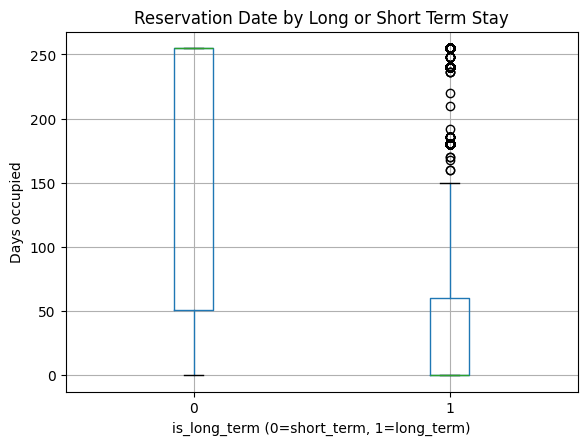

                   count       mean         std  min  25%  50%    75%    max
room_type                                                                   
Entire home/apt  12664.0  72.955701   95.869472  0.0  0.0  0.0  120.0  255.0
Hotel room         372.0  12.591398   40.728868  0.0  0.0  0.0    0.0  255.0
Private room      9186.0  71.979643   98.426854  0.0  0.0  0.0  120.0  255.0
Shared room         86.0  76.988372  105.721331  0.0  0.0  0.0  180.0  255.0


<Figure size 800x500 with 0 Axes>

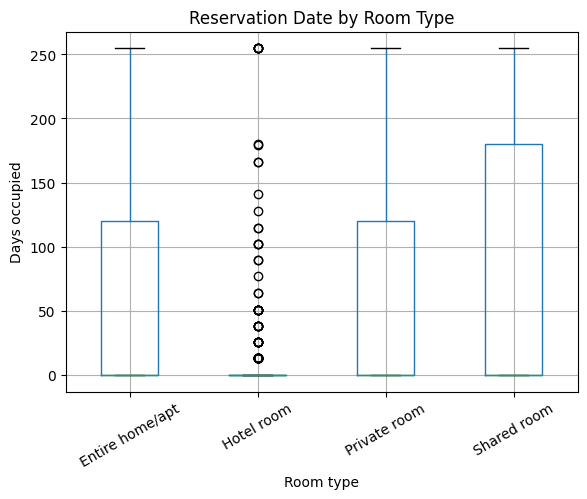

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

TARGET = "estimated_occupancy_l365d"

# 1‑1. is_long_term 그룹별 요약
print(df.groupby("is_long_term")[TARGET].describe())

# 박스플롯
plt.figure(figsize=(6,4))
df.boxplot(column=TARGET, by="is_long_term")
plt.title("Reservation Date by Long or Short Term Stay")
plt.suptitle("")
plt.xlabel("is_long_term (0=short_term, 1=long_term)")
plt.ylabel("Days occupied")
plt.show()

# 1‑2. room_type 그룹별 요약
# (원핫된 컬럼이 아니라, raw 컬럼이 있어야 합니다)
print(df.groupby('room_type')[TARGET].describe())

plt.figure(figsize=(8,5))
df.boxplot(column=TARGET, by="room_type")
plt.xticks(rotation=30)
plt.title("Reservation Date by Room Type")
plt.suptitle("")
plt.xlabel("Room type")
plt.ylabel("Days occupied")
plt.show()


In [65]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score


print("==== Entire Data ====")
# 2) 타깃과 피처 선택
TARGET = "estimated_occupancy_l365d"
# 유의미하다고 판단된 피처 리스트
features = [
    "price", "availability_365",
    "is_long_term",
    "amenities_cnt", "accommodates", "bath_score_mul", "beds",
    "number_of_reviews",
    "review_scores_rating",
    "name_length_group", "description_length_group", "neighborhood_overview_exists",
    "host_about_length_group", "host_is_superhost", "host_has_profile_pic",
    "host_response_rate_score",
    "host_location_ny",
    "town_encoded",
    "structure_encoded"
]

X = df[features].copy()
y = df[TARGET].copy()

# 3) 결측치 처리 (예시: 0으로 채우기 또는 중앙값)
X = X.fillna(0)


# 5) 학습/검증 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 6) RandomForest 모델 학습 및 평가
print("=== RandomForest ===")
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_rf = rf.predict(X_test)
print("RandomForest RMSE:", root_mean_squared_error(y_test, y_rf))
print("RandomForest MAE :", mean_absolute_error(y_test, y_rf))
print("RandomForest R2 score :", r2_score(y_test, y_rf))

# 7) XGBoost 모델 학습 및 평가
print("=== XGBoost ===")
xgb = XGBRegressor(
    n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42,
    objective='reg:squarederror', eval_metric='rmse'
)
xgb.fit(X_train, y_train)
y_xgb = xgb.predict(X_test)
print("XGBoost     RMSE:", root_mean_squared_error(y_test, y_xgb))
print("XGBoost     MAE :", mean_absolute_error(y_test, y_xgb))
print("XGBoost     R2 score :", r2_score(y_test, y_rf))


==== Entire Data ====
=== RandomForest ===
RandomForest RMSE: 51.93712275345056
RandomForest MAE : 31.85134580905424
RandomForest R2 score : 0.7053760160998354
=== XGBoost ===
XGBoost     RMSE: 51.784080505371094
XGBoost     MAE : 32.602848052978516
XGBoost     R2 score : 0.7053760160998354


In [69]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

# 랜덤 포레스트

# 1) 기본 모델 객체 생성
rf = RandomForestRegressor(random_state=42)

# 2) 탐색할 하이퍼파라미터 분포 정의
#    리스트나 분포 객체로 값의 후보를 넣어 줍니다.
param_dist = {
    "n_estimators": [100, 200, 500],     # 트리 개수
    "max_depth":    [None, 5, 10, 20],   # 트리 깊이
    "min_samples_split": [2, 5, 10],     # 노드 분할 최소 샘플 수
    "min_samples_leaf":  [1, 2, 4]       # 잎사귀 노드 최소 샘플 수
}

# 3) RandomizedSearchCV 객체 설정
search = RandomizedSearchCV(
    estimator=rf,            # 어떤 모델(rf)
    param_distributions=param_dist,
    n_iter=20,               # 시도할 파라미터 조합 수
    cv=3,                    # 3‑폴드 교차검증
    scoring="neg_mean_squared_error",  # 평가 지표
    random_state=42,         # 재현성 시드
    n_jobs=-1                # 병렬 처리
)

# 4) 학습 데이터로 탐색 수행
search.fit(X_train, y_train)

# 5) 최적 파라미터 & 모델 확인
print("=== 랜덤포레스트 최적 파라미터 ===")
print("✔ Best rf params:", search.best_params_)
best_rf = search.best_estimator_



# xgboost
xgb = XGBRegressor(
    objective="reg:squarederror",
    random_state=42
)

# 2) 탐색할 하이퍼파라미터 분포(리스트) 정의
xgb_param_dist = {
    "n_estimators":      [100, 200, 500],
    "learning_rate":     [0.01, 0.05, 0.1],
    "max_depth":         [3, 5, 7],
    "subsample":         [0.6, 0.8, 1.0],
    "colsample_bytree":  [0.6, 0.8, 1.0]
}

# 3) RandomizedSearchCV 설정
xgb_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_dist,
    n_iter=20,                     # 시도 조합 수
    cv=3,                          # 3‑폴드 교차검증
    scoring="neg_mean_squared_error",
    random_state=42,
    n_jobs=-1
)

# 4) 학습 데이터(X_train, y_train)로 검색 수행
xgb_search.fit(X_train, y_train)

# 5) 결과 출력
print("=== xgboost 최적 파라미터 ===")
print("✔ Best XGB params:", xgb_search.best_params_)

# 6) 최적 모델 꺼내기
best_xgb = xgb_search.best_estimator_

=== 랜덤포레스트 최적 파라미터 ===
✔ Best rf params: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 20}
=== xgboost 최적 파라미터 ===
✔ Best XGB params: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


In [71]:
print("==== 최적의 파라미터 찾은 후 모델링 ====")

# 1) 데이터 (예: 이미 로드된 df 사용)

# 2) 타깃과 피처
TARGET = "estimated_occupancy_l365d"
features = [
    "price", "availability_365",
    "is_long_term",
    "amenities_cnt", "accommodates", "bath_score_mul", "beds",
    "number_of_reviews",
    "review_scores_rating",
    "name_length_group", "description_length_group", "neighborhood_overview_exists",
    "host_about_length_group", "host_is_superhost", "host_has_profile_pic",
    "host_response_rate_score",
    "host_location_ny",
    "town_encoded",
    "structure_encoded"
]

X = df[features].fillna(0)
y = df[TARGET]

# 3) 학습/검증 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4) RandomForest with Best Params
print("=== RandomForest (tuned) ===")
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
rf.fit(X_train, y_train)
y_rf = rf.predict(X_test)
print("RF RMSE:", root_mean_squared_error(y_test, y_rf))
print("RF MAE :", mean_absolute_error(y_test, y_rf))
print("RF R2  :", r2_score(y_test, y_rf))

# 5) XGBoost (기본 또는 튜닝 반영)
print("\n=== XGBoost ===")
xgb = XGBRegressor(
    subsample=0.8,
    n_estimators=100,
    learning_rate=0.05,
    max_depth=7,
    random_state=42,
    colsample_bytree=0.8
)
xgb.fit(X_train, y_train)
y_xgb = xgb.predict(X_test)
print("XGB RMSE:", root_mean_squared_error(y_test, y_xgb))
print("XGB MAE :", mean_absolute_error(y_test, y_xgb))
print("XGB R2  :", r2_score(y_test, y_xgb))


==== 최적의 파라미터 찾은 후 모델링 ====
=== RandomForest (tuned) ===
RF RMSE: 51.70282328860463
RF MAE : 31.60570491879913
RF R2  : 0.7080282437558013

=== XGBoost ===
XGB RMSE: 51.763153076171875
XGB MAE : 32.665618896484375
XGB R2  : 0.707346498966217


In [72]:
import numpy as np
from sklearn.ensemble import VotingRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV


# ▶ 1) 이미 준비된 튜닝된 모델 불러오기
#    best_rf, best_xgb, X_train, X_test, y_train, y_test 는 
#    앞 셀에서 RandomizedSearchCV 를 통해 얻은 객체 및 split 데이터입니다.

# ▶ 2) Voting 앙상블 (단순 평균)
voting = VotingRegressor([
    ('rf',  best_rf),
    ('xgb', best_xgb)
], n_jobs=-1)

voting.fit(X_train, y_train)
y_vot = voting.predict(X_test)

# 성능 지표 계산 함수
def eval(y_true, y_pred):
    return {
        'RMSE': root_mean_squared_error(y_true, y_pred),
        'MAE':  mean_absolute_error(y_true, y_pred),
        'R2':   r2_score(y_true, y_pred)
    }

print("=== VotingRegressor Performance ===")
print(eval(y_test, y_vot))


# ▶ 3) Stacking 앙상블 (메타 모델: RidgeCV)
stack = StackingRegressor(
    estimators=[
        ('rf',  best_rf),
        ('xgb', best_xgb)
    ],
    final_estimator=RidgeCV(),
    cv=3,
    n_jobs=-1,
    passthrough=False        # (메타모델에 원본 피처도 같이 넘기고 싶으면 True)
)

stack.fit(X_train, y_train)
y_stack = stack.predict(X_test)

print("\n=== StackingRegressor Performance ===")
print(eval(y_test, y_stack))


=== VotingRegressor Performance ===
{'RMSE': 51.318717077095556, 'MAE': 31.976594987518258, 'R2': 0.7123503127359099}

=== StackingRegressor Performance ===
{'RMSE': 51.29959618897662, 'MAE': 31.95589401534417, 'R2': 0.7125646241276946}


In [77]:
print("==== activate_data ====")

activate_df = df[df['is_activate'] == 1]

TARGET = "estimated_occupancy_l365d"
# 유의미하다고 판단된 피처 리스트
features = [
    "price", "availability_365",
    "is_long_term",
    "amenities_cnt", "accommodates", "bath_score_mul", "beds",
    "number_of_reviews",
    "review_scores_rating",
    "name_length_group", "description_length_group", "neighborhood_overview_exists",
    "host_about_length_group", "host_is_superhost", "host_has_profile_pic",
    "host_response_rate_score",
    "host_location_ny",
    "town_encoded",
    "structure_encoded"
]

X = activate_df[features].copy()
y = activate_df[TARGET].copy()

# 3) 결측치 처리 (예시: 0으로 채우기 또는 중앙값)
X = X.fillna(0)

# 데이터 훈련
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 최적 파라미터 값 찾기
# 랜덤 포레스트

# 1) 기본 모델 객체 생성
rf = RandomForestRegressor(random_state=42)

# 2) 탐색할 하이퍼파라미터 분포 정의
#    리스트나 분포 객체로 값의 후보를 넣어 줍니다.
param_dist = {
    "n_estimators": [100, 200, 500],     # 트리 개수
    "max_depth":    [None, 5, 10, 20],   # 트리 깊이
    "min_samples_split": [2, 5, 10],     # 노드 분할 최소 샘플 수
    "min_samples_leaf":  [1, 2, 4]       # 잎사귀 노드 최소 샘플 수
}

# 3) RandomizedSearchCV 객체 설정
search = RandomizedSearchCV(
    estimator=rf,            # 어떤 모델(rf)
    param_distributions=param_dist,
    n_iter=20,               # 시도할 파라미터 조합 수
    cv=3,                    # 3‑폴드 교차검증
    scoring="neg_mean_squared_error",  # 평가 지표
    random_state=42,         # 재현성 시드
    n_jobs=-1                # 병렬 처리
)

# 4) 학습 데이터로 탐색 수행
search.fit(X_train, y_train)

# 5) 최적 파라미터 & 모델 확인
print("=== 랜덤포레스트 최적 파라미터 ===")
print("✔ Best rf params:", search.best_params_)
best_rf = search.best_estimator_



# xgboost
xgb = XGBRegressor(
    objective="reg:squarederror",
    random_state=42
)

# 2) 탐색할 하이퍼파라미터 분포(리스트) 정의
xgb_param_dist = {
    "n_estimators":      [100, 200, 500],
    "learning_rate":     [0.01, 0.05, 0.1],
    "max_depth":         [3, 5, 7],
    "subsample":         [0.6, 0.8, 1.0],
    "colsample_bytree":  [0.6, 0.8, 1.0]
}

# 3) RandomizedSearchCV 설정
xgb_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_dist,
    n_iter=20,                     # 시도 조합 수
    cv=3,                          # 3‑폴드 교차검증
    scoring="neg_mean_squared_error",
    random_state=42,
    n_jobs=-1
)

# 4) 학습 데이터(X_train, y_train)로 검색 수행
xgb_search.fit(X_train, y_train)

# 5) 결과 출력
print("=== xgboost 최적 파라미터 ===")
print("✔ Best XGB params:", xgb_search.best_params_)

# 6) 최적 모델 꺼내기
best_xgb = xgb_search.best_estimator_

==== activate_data ====
=== 랜덤포레스트 최적 파라미터 ===
✔ Best rf params: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 20}
=== xgboost 최적 파라미터 ===
✔ Best XGB params: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


In [78]:
print("==== 최적의 파라미터 찾은 후 활성화된 숙소 모델링 ====")

# 1) 데이터 (예: 이미 로드된 df 사용)

# 2) 타깃과 피처
TARGET = "estimated_occupancy_l365d"
features = [
    "price", "availability_365",
    "is_long_term",
    "amenities_cnt", "accommodates", "bath_score_mul", "beds",
    "number_of_reviews",
    "review_scores_rating",
    "name_length_group", "description_length_group", "neighborhood_overview_exists",
    "host_about_length_group", "host_is_superhost", "host_has_profile_pic",
    "host_response_rate_score",
    "host_location_ny",
    "town_encoded",
    "structure_encoded"
]

X = activate_df[features].fillna(0)
y = activate_df[TARGET]

# 3) 학습/검증 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4) RandomForest with Best Params
print("=== RandomForest (tuned) ===")
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42
)
rf.fit(X_train, y_train)
y_rf = rf.predict(X_test)
print("RF RMSE:", root_mean_squared_error(y_test, y_rf))
print("RF MAE :", mean_absolute_error(y_test, y_rf))
print("RF R2  :", r2_score(y_test, y_rf))

# 5) XGBoost (기본 또는 튜닝 반영)
print("\n=== XGBoost ===")
xgb = XGBRegressor(
    subsample=0.8,
    n_estimators=100,
    learning_rate=0.05,
    max_depth=7,
    random_state=42,
    colsample_bytree=0.8
)
xgb.fit(X_train, y_train)
y_xgb = xgb.predict(X_test)
print("XGB RMSE:", root_mean_squared_error(y_test, y_xgb))
print("XGB MAE :", mean_absolute_error(y_test, y_xgb))
print("XGB R2  :", r2_score(y_test, y_xgb))


==== 최적의 파라미터 찾은 후 활성화된 숙소 모델링 ====
=== RandomForest (tuned) ===
RF RMSE: 61.64357567105829
RF MAE : 42.913288322138484
RF R2  : 0.6313522444904693

=== XGBoost ===
XGB RMSE: 61.216739654541016
XGB MAE : 43.963340759277344
XGB R2  : 0.6364398002624512


In [ ]:
print("==== is_activate 추가후 모델링 ====")

# 1) 데이터 (예: 이미 로드된 df 사용)

# 2) 타깃과 피처
TARGET = "estimated_occupancy_l365d"
features = [
    "price", "availability_365",
    "is_long_term",
    "is_activate",
    "amenities_cnt", "accommodates", "bath_score_mul", "beds",
    "number_of_reviews",
    "review_scores_rating",
    "name_length_group", "description_length_group", "neighborhood_overview_exists",
    "host_about_length_group", "host_is_superhost", "host_has_profile_pic",
    "host_response_rate_score",
    "host_location_ny",
    "town_encoded",
    "structure_encoded"
]

X = df[features].fillna(0)
y = df[TARGET]

# 3) 학습/검증 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4) RandomForest with Best Params
print("=== RandomForest (tuned) ===")
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
rf.fit(X_train, y_train)
y_rf = rf.predict(X_test)
print("RF RMSE:", root_mean_squared_error(y_test, y_rf))
print("RF MAE :", mean_absolute_error(y_test, y_rf))
print("RF R2  :", r2_score(y_test, y_rf))

# 5) XGBoost (기본 또는 튜닝 반영)
print("\n=== XGBoost ===")
xgb = XGBRegressor(
    subsample=0.8,
    n_estimators=100,
    learning_rate=0.05,
    max_depth=7,
    random_state=42,
    colsample_bytree=0.8
)
xgb.fit(X_train, y_train)
y_xgb = xgb.predict(X_test)
print("XGB RMSE:", root_mean_squared_error(y_test, y_xgb))
print("XGB MAE :", mean_absolute_error(y_test, y_xgb))
print("XGB R2  :", r2_score(y_test, y_xgb))


==== 최적의 파라미터 찾은 후 모델링 ====
=== RandomForest (tuned) ===
RF RMSE: 49.505518143611255
RF MAE : 28.90271637844374
RF R2  : 0.7323177678054889

=== XGBoost ===
XGB RMSE: 49.64118576049805
XGB MAE : 30.099824905395508
XGB R2  : 0.7308486700057983


In [81]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1) 데이터 불러오기 & 피처/타깃 설정
TARGET = "estimated_occupancy_l365d"
features = [  # 앞서 선정한 피처 리스트
    "price", "availability_365",
    "is_long_term", "is_activate", "amenities_cnt", "accommodates",
    "bath_score_mul", "beds", "number_of_reviews", 
    "review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness",
    "review_scores_checkin", "review_scores_communication", "review_scores_location",
    "review_scores_value", "name_length_group", "description_length_group",
    "neighborhood_overview_exists", "host_about_length_group", "host_is_superhost",
    "host_has_profile_pic", "host_response_time_score", "host_response_rate_score",
    "host_acceptance_rate_score", "host_location_ny", "town_encoded",
    "neighbourhood_group_cleansed_Bronx", "neighbourhood_group_cleansed_Brooklyn",
    "neighbourhood_group_cleansed_Manhattan", "neighbourhood_group_cleansed_Queens",
    "room_type_Entire home/apt", "room_type_Hotel room", "structure_encoded"
]
X = df[features].fillna(0)
y = df[TARGET]

# 2) 학습/검증 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3) 하이퍼파라미터 분포 설정
rf = RandomForestRegressor(random_state=42)
rf_params = {
    "n_estimators": [100, 200, 500],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

xgb = XGBRegressor(objective="reg:squarederror", random_state=42)
xgb_params = {
    "n_estimators": [100, 200, 500],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

# 4) RandomizedSearchCV
rf_search = RandomizedSearchCV(
    rf, rf_params, n_iter=20, cv=3, scoring="neg_mean_squared_error", random_state=42, n_jobs=-1
)
rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_

xgb_search = RandomizedSearchCV(
    xgb, xgb_params, n_iter=20, cv=3, scoring="neg_mean_squared_error", random_state=42, n_jobs=-1
)
xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_

print("✔ Best RF params:", rf_search.best_params_)
print("✔ Best XGB params:", xgb_search.best_params_)

# 5) 검증 성능 (튜닝 후)
def eval_model(model, X_t, y_t):
    y_pred = model.predict(X_t)
    return np.sqrt(mean_squared_error(y_t, y_pred)), mean_absolute_error(y_t, y_pred)

rf_rmse, rf_mae = eval_model(best_rf, X_test, y_test)
xgb_rmse, xgb_mae = eval_model(best_xgb, X_test, y_test)
print(f"RF tuned  RMSE={rf_rmse:.2f}, MAE={rf_mae:.2f}")
print(f"XGB tuned RMSE={xgb_rmse:.2f}, MAE={xgb_mae:.2f}")

# 6) Ensemble: Voting Regressor
voting = VotingRegressor([("rf", best_rf), ("xgb", best_xgb)])
voting.fit(X_train, y_train)
v_rmse, v_mae = eval_model(voting, X_test, y_test)
print(f"Voting   RMSE={v_rmse:.2f}, MAE={v_mae:.2f}")

# 7) Ensemble: Stacking Regressor
stack = StackingRegressor(
    estimators=[("rf", best_rf), ("xgb", best_xgb)],
    final_estimator=RidgeCV(),
    cv=3,
    n_jobs=-1
)
stack.fit(X_train, y_train)
s_rmse, s_mae = eval_model(stack, X_test, y_test)
print(f"Stacking RMSE={s_rmse:.2f}, MAE={s_mae:.2f}")


✔ Best RF params: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}
✔ Best XGB params: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
RF tuned  RMSE=48.82, MAE=28.47
XGB tuned RMSE=48.52, MAE=29.42
Voting   RMSE=48.31, MAE=28.77
Stacking RMSE=48.24, MAE=28.93


In [ ]:
df['number_of_reviews']